# Tutorial

`micromodelsim` enables the simulation of diffusion-weighted nuclear magnetic resonance (NMR) measurements using microstructural models. This minimal tutorial covers its basic functionality, and we recommend the reader to also look at [the reference](https://micromodelsim.rtfd.io/en/latest/reference.html) where essential details are provided.

Let's start by importing the required packages.


In [1]:
import os

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import micromodelsim as mmsim

## Gradients

Gradient information is stored in a `Gradient` object. The code below defines and visualizes a two-shell acquisition protocol.

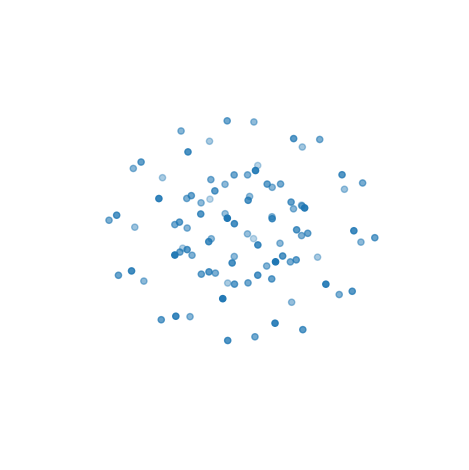

In [2]:
bvecs = np.array(
    [
        [0.283, 0.283, 0.917],
        [-0.283, 0.283, 0.917],
        [-0.283, -0.283, 0.917],
        [0.283, -0.283, 0.917],
        [0.689, 0.285, 0.667],
        [0.285, 0.689, 0.667],
        [-0.285, 0.689, 0.667],
        [-0.689, 0.285, 0.667],
        [-0.689, -0.285, 0.667],
        [-0.285, -0.689, 0.667],
        [0.285, -0.689, 0.667],
        [0.689, -0.285, 0.667],
        [0.943, 0.0, 0.333],
        [0.667, 0.667, 0.333],
        [0.0, 0.943, 0.333],
        [-0.667, 0.667, 0.333],
        [-0.943, 0.0, 0.333],
        [-0.667, -0.667, 0.333],
        [-0.0, -0.943, 0.333],
        [0.667, -0.667, 0.333],
        [0.924, 0.383, 0.0],
        [0.383, 0.924, 0.0],
        [-0.383, 0.924, 0.0],
        [-0.924, 0.383, 0.0],
    ]
)

bvecs = np.concatenate((bvecs, -bvecs))

bvals = np.concatenate((np.ones(len(bvecs)), 2 * np.ones(len(bvecs))))

bvecs = np.vstack((bvecs, bvecs))

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(bvals * bvecs[:, 0], bvals * bvecs[:, 1], bvals * bvecs[:, 2])
ax.set_axis_off()
fig.tight_layout()
plt.show()

gradient = mmsim.Gradient(bvals, bvecs)

## Diffusion tensor distribution simulation

The function `dtd_simulation` enables simulating measurements from a diffusion tensor distribution (DTD). The signal is given by the following equation:

$$S = \sum_{i=1}^N f_i \exp \left( -\mathbf{b}:\mathbf{D}_i \right)$$

where $N$ is the number of diffusion tensors, $f_i$ is a signal fraction, $\mathbf{b}$ is the b-tensor, $\mathbf{D}_i$ is a diffusion tensor, and $:$ denotes the generalized scalar product.

The code below generates signals from a simple DTD using the acquisition protocol defined above.

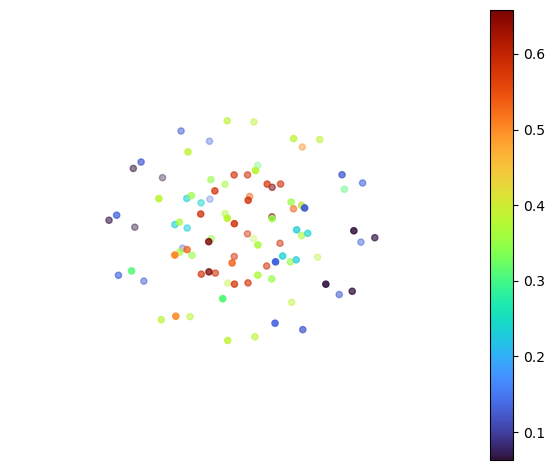

In [3]:
dtd = np.array(
    [
        [[2, 0, 0], [0, 0, 0], [0, 0, 0]],
        [[2, 0, 0], [0, 0.5, 0], [0, 0, 0.5]],
        [[1, 0, 0], [0, 1, 0], [0, 0, 1]],
    ]
)  # the array has to have shape (number of tensors, 3, 3)

signals = mmsim.dtd_simulation(gradient, dtd)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
im = ax.scatter(
    bvals * bvecs[:, 0],
    bvals * bvecs[:, 1],
    bvals * bvecs[:, 2],
    c=signals,
    cmap="turbo",
)
plt.colorbar(im)
ax.set_axis_off()
fig.tight_layout()
plt.show()

## Compartment model simulation

The function `compartment_model_simulation` enables simulating measurements from a Gaussian compartment model and an orientation distribution function (ODF).

The signal is expressed as a spherical convolution of the ODF by a microstructural kernel response function $K$:

$$S(\mathbf{x}) = \int_{\mathbf{R} \in \text{SO}(3)} \text{d}\mathbf{R} \ \text{ODF}(\mathbf{R} \mathbf{\hat{e}_3}) K(\mathbf{R}^{-1} \mathbf{x})$$

where $\mathbf{x} \in S^2$ is the diffusion encoding direction and

$$K(\mathbf{\hat{n}}) = \sum_{i=1}^N f_i \exp(- \mathbf{b}:\mathbf{D}_i)$$

where $N$ is the number of compartments, $f_i$ is a signal fraction, $\mathbf{b}$ is the b-tensor corresponding to $\mathbf{x}$ and a b-value equal to $\text{Tr}(\mathbf{b})$, $:$ denotes the generalized scalar product, and $\mathbf{D}_i$ is a diffusion tensor aligned with the $z$-axis.

### ODFs

ODFs must be represented as spherical harmonics expansions. The ODFs don't have to be normalized as the `compartment_model_simulation` function does the normalization.

Because reconstructed diffusion MRI signals are real-valued and antipodally symmetric, the following basis is used:

$$S_l^m = \left\{\begin{matrix} 0 & \text{if } l \text{ is odd} \\ \sqrt{2} \ \Im \left( Y_l^{-m} \right) & \text{if} \ m < 0 \\  Y_l^0 & \text{if} \ m = 0 \\ \sqrt{2} \ \Re \left( Y_l^{m} \right) & \text{if} \ m > 0  \end{matrix}\right. $$

where where $l$ is the degree of the spherical harmonic, $m$ is the order, and

$$Y_l^m(\theta, \phi) = \sqrt{\frac{2l + 1}{4 \pi} \frac{(l - m)!} {(l + m)!}} P_l^m(\cos \theta) e^{im\phi}$$

ODFs must be represented as a 1D arrays using the following indexing:

$$i = \frac{1}{2}l(l + 1) + m$$

The number of coefficients $N$ depends on $l_\text{max}$:

$$N = \frac{1}{2}(l_\text{max} + 1)(l_\text{max} + 2)$$

The code below defines and visualizes a spherical harmonics expansion with $l_\text{max} = 8$.

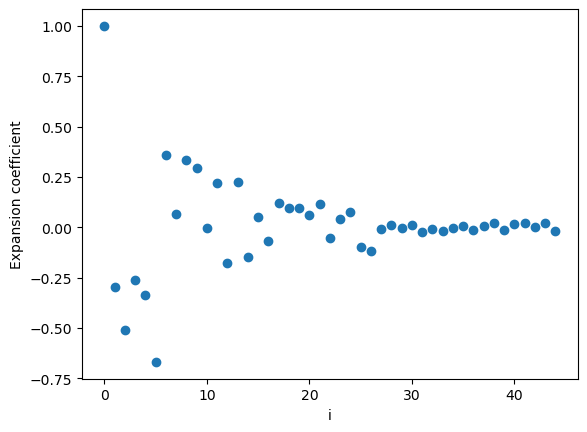

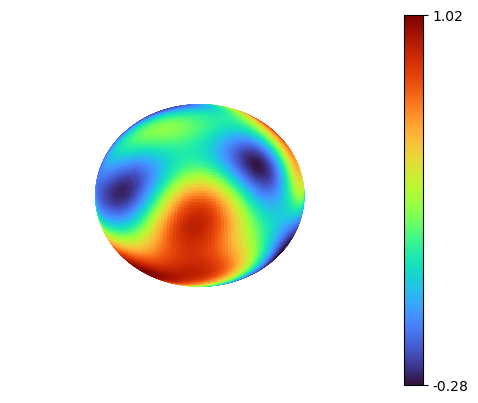

In [4]:
l_max = 8
n_coeffs = int(0.5 * (l_max + 1) * (l_max + 2))

l0s = np.zeros(n_coeffs)
for l in range(0, l_max + 1, 2):
    for m in range(-l, l + 1):
        l0s[int(0.5 * l * (l + 1) + m)] = int(0.5 * l * (l + 1))

coeffs = np.exp(-l0s / 10)  # spherical harmonic expansion coefficients
np.random.seed(666)
coeffs[1::] *= 2 * (0.5 - np.random.random(n_coeffs - 1))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(np.arange(n_coeffs), coeffs)
ax.set_xlabel("i")
ax.set_ylabel("Expansion coefficient")
plt.show()

N = 100  # determines the resolution of the ODF visualization
thetas, phis = np.meshgrid(np.linspace(0, np.pi, N), np.linspace(0, 2 * np.pi, 2 * N))
x = np.sin(thetas) * np.cos(phis)
y = np.sin(thetas) * np.sin(phis)
z = np.cos(thetas)

values = np.zeros(x.shape)
for l in range(0, l_max + 1, 2):
    for m in range(-l, l + 1):
        i = int(0.5 * l * (l + 1) + m)
        values += coeffs[i] * mmsim.sh(l, m, thetas, phis)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
fcolors = (values - np.min(values)) / (np.max(values) - np.min(values))
im = ax.plot_surface(
    x,
    y,
    z,
    rcount=2 * N,
    ccount=N,
    facecolors=matplotlib.cm.turbo(fcolors),
    cmap="turbo",
)
cbar = plt.colorbar(im)
cbar.set_ticks([0, 1])
cbar.set_ticklabels([np.round(np.min(values), 2), np.round(np.max(values), 2)])
ax.set_axis_off()
plt.show()

The code below generates 

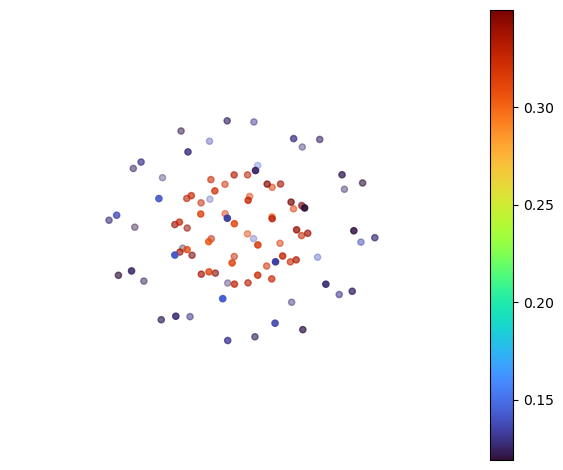

In [5]:
fs = np.array([0.8, 0.2])[np.newaxis]
ads = np.array([2, 0])[np.newaxis]
rds = np.array([1, 1])[np.newaxis]
odfs_sh = coeffs[np.newaxis]
signals = mmsim.compartment_model_simulation(gradient, fs, ads, rds, odfs_sh)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
im = ax.scatter(
    bvals * bvecs[:, 0],
    bvals * bvecs[:, 1],
    bvals * bvecs[:, 2],
    c=signals,
    cmap="turbo",
)
plt.colorbar(im)
ax.set_axis_off()
fig.tight_layout()
plt.show()